<!-- <table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/DrPBaksh/image_processing/main/logos/logo_2.png?raw=true" alt="Corndel" width="301.5" height="216"></td>
    <td><img src="https://github.com/CorndelDataAnalyticsDiploma/workshop/blob/master/Corndel%20Digital%20Logo%20Centre.png?raw=true" alt="Corndel" width="301.5" height="216"></td>
  </tr>
</table> -->


<img src="https://raw.githubusercontent.com/DrPBaksh/image_processing/main/logos/logo_2.png?raw=true" alt="Corndel" width ="301.5" height=216>

<!-- <img src="https://github.com/CorndelDataAnalyticsDiploma/workshop/blob/master/Corndel%20Digital%20Logo%20Centre.png?raw=true" alt="Corndel" width ="301.5" height=216> -->

# Time Series Forecasting 3 : Extra

This notebook is going to demonstrate how to apply further time series algorithms to time dependant data. Due to the amount of content in the notebook we may skip over some sections that you can look at later

**Today**
- Import dataset 1
- Time Series Decomposition
- Make Prediction using ETS algorithm
- Decide on the appropriate ARMA SARIMA ARIMA algorthm and apply
- Import more complicated datset
- Apply Linear Regression and XGboost Regression for time series forecasting
- Apply FB Prophet



In [1]:

import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics import tsaplots 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn import metrics
import numpy as np

from scipy import stats
import seaborn as sns

C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\PeterBaksh\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\PeterBaksh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/airline_passengers.csv?raw=true', parse_dates = True)
df.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


**Both ETS and Arima in Python require that the datetime component is in the index of the dataframe**

In [3]:
df.Month = pd.to_datetime(df['Month'])
df.set_index('Month', inplace = True)

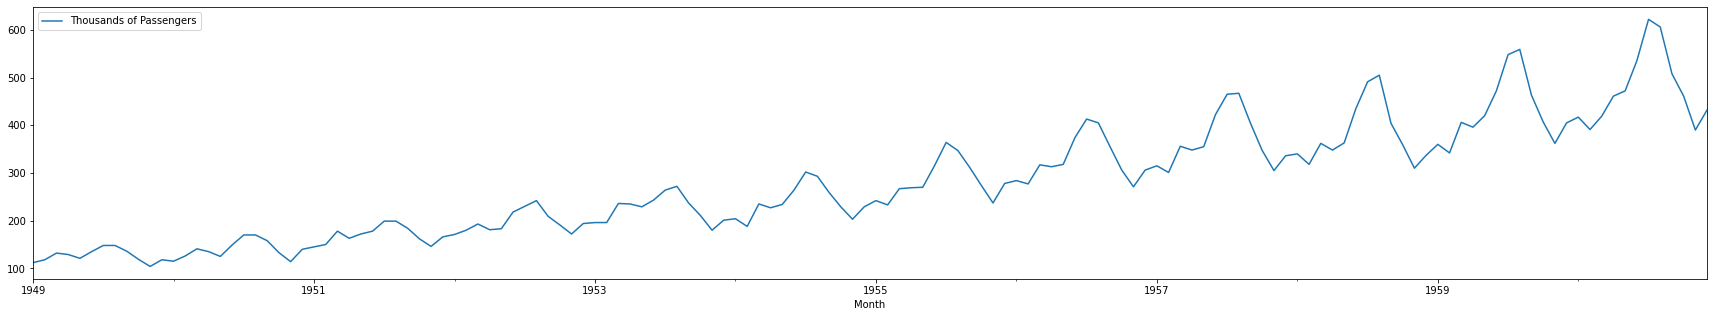

In [4]:
df.plot(y = 'Thousands of Passengers')
fig = plt.gcf()
fig.set_size_inches(30, 5)

**Set the frequency of the dataframe. Remember if this errors it indicates you have an incomplete time series**

In [5]:
df.index.freq = 'MS'

**Split the data into Training and Testing sets**

In time series we do this by time and not by random samples. 

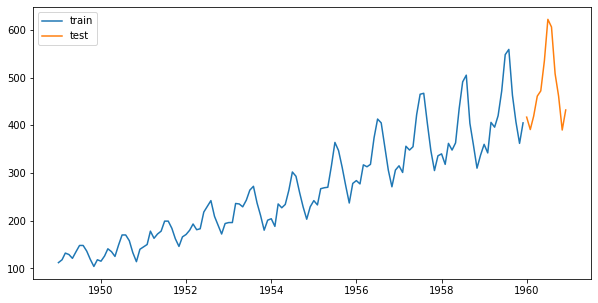

In [6]:
train = df.loc[:'1959']
test = df.loc['1960']
fig = plt.figure(figsize = (10, 5))
plt.plot(train.index, train.values)
plt.plot(test.index, test.values)
plt.legend(['train', 'test'])

**Apply Seasonal Decomposition on your data - Remember look at the residual to see if there is any structure left in your data. If there is try a different model or it could be there is a further seasonality**

In [7]:
decomp=seasonal_decompose(train['Thousands of Passengers'],model='multiplicative')

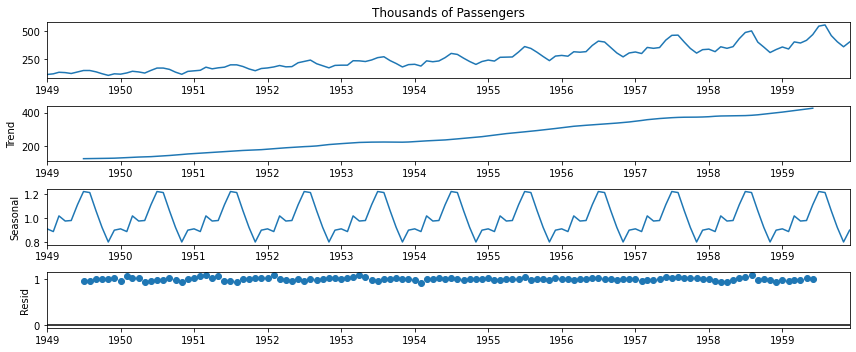

In [8]:
fig = decomp.plot()
fig.set_size_inches((12, 5))
fig.tight_layout()
plt.show();

## Identifying the Period of Seasonality

**ACF and PCF**

Now that we have the trend identified in the data we can removed the trend to obtan infomation on seasonal features. Both the ACF and PCF can show this 

The Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) are tools used in time series analysis to identify the underlying structure of the data. Both are used to determine the degree of correlation between a time series and its past values. The ACF measures the correlation between a time series and its lagged values, while the PACF measures the correlation between a time series and its lagged values after accounting for the effect of all the intermediate lags. In other words, the PACF shows the direct effect of each lag on the current value, while the ACF shows the cumulative effect of all lags up to that point.

Another way of looking at this is the ACF takes the data at a lag time t and plots that against itself.

However the pcf will perform a regression in time where it looks to see how well data at t = 0 correlates with t = t including all the points between t = 0 and t = t. It therefore can be more sensitive to the specific correlation after a number of lags

In [9]:
detrended = pd.DataFrame({'date' : train.index, 'detrended': decomp.observed.values -decomp.trend.values}).set_index('date')
detrended = detrended.dropna()

C:\Users\PeterBaksh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


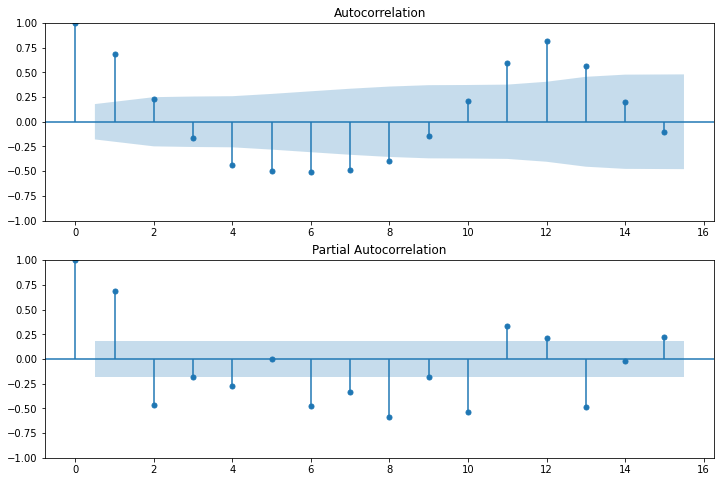

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(detrended, ax=ax1, lags=15)
plot_pacf(detrended, ax=ax2, lags=15)
plt.show()

**For now we shall just look at the ACF that shows a period of 12 lags.  Lets now plot the ETS model remebering that after a grid search from the previous workshop we found the Error was mul, the Trend was add and the seasonal mul. We are going to be working with a variety of models so we shall create a dataframe to store out results so we can make quantitive comparision. Below we have some code that will calculate varipus metrics on our training and testing data and provide a results dataframe.**


In [11]:
def update_results(model_name, data_name, results, train, train_fit, test, test_forecast):
    try:
        res = {}
        res['train_rmse'] = [np.sqrt(np.mean((train.values - train_fit.values)**2)).round(2)]
        res['test_rmse'] = [np.sqrt(np.mean((test.values - test_forecast.values)**2)).round(2)]
        res['train_mape'] = [100*metrics.mean_absolute_percentage_error(train, train_fit).round(2)]
        res['test_mape'] = [100*metrics.mean_absolute_percentage_error(test, test_forecast).round(2)]
        res['train_r2'] = [metrics.r2_score(train, train_fit).round(2)]
        res['test_r2'] = [metrics.r2_score(test, test_forecast).round(2)]
        res['model'] = [model_name]
        res['data'] = [data_name]
        results = pd.concat([results, pd.DataFrame(res)])
    except:
        res['train_rmse'] = [np.sqrt(np.mean((train.values - train_fit)**2)).round(2)]
        res['test_rmse'] = [np.sqrt(np.mean((test.values - test_forecast)**2)).round(2)]
        res['train_mape'] = [100*metrics.mean_absolute_percentage_error(train, train_fit).round(2)]
        res['test_mape'] = [100*metrics.mean_absolute_percentage_error(test, test_forecast).round(2)]
        res['train_r2'] = [metrics.r2_score(train, train_fit).round(2)]
        res['test_r2'] = [metrics.r2_score(test, test_forecast).round(2)]
        res['model'] = [model_name]
        res['data'] = [data_name]
        results = pd.concat([results, pd.DataFrame(res)])
        
    return results

results = pd.DataFrame(columns = ['model', 'data', 'train_rmse', 'train_mape', 'train_r2', 'test_rmse', 'test_mape', 'test_r2'])
results

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2


**Create ets model to make predictions on airline passenger data**

In [12]:
model= sm.tsa.ETSModel(train['Thousands of Passengers'].astype('float64'),
                                error='mul',          # CHANGE THIS TO BE add or mul          
                                trend='add',          # CHANGE THIS TO BE add or mul
                                damped_trend=True,   # CHANGE THIS TO BE True or False
                                seasonal='mul',       # CHANGE THIS TO BE add or mul
                                seasonal_periods=12,
                                freq='MS').fit()

**Take time to understand the next block of code because we repeat this numerous times**

- trian_fit_ets is the fitted values of the algorithm over the training data
- train_forecast_ets is the models forecast into the future beyond the training data. We are going to forecast data the length of the testing data
- the update results function takes the orignal data, train and test in this case the the fitted results and the forecast results and it calculates the RMSE, MAPE and R2 for this model

In [13]:
train_fit_ets = model.fittedvalues
test_forecast_ets = model.forecast(steps = len(test))
results = update_results('ets', 'airpassenger',results, train, train_fit_ets, test, test_forecast_ets)
results

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86


**We now have our first result. Lets visualise what is going on in the forecast**

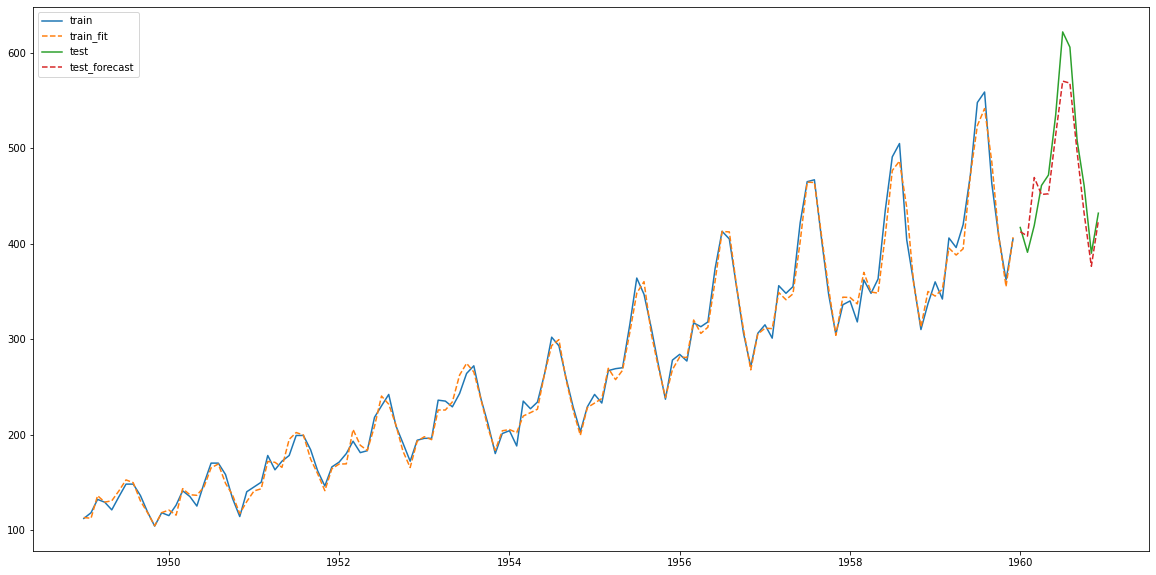

In [14]:
plt.plot(train.index, train['Thousands of Passengers'])
plt.plot(train.index, train_fit_ets, '--')
plt.plot(test.index, test['Thousands of Passengers'])
plt.plot(test.index, test_forecast_ets, '--')
plt.legend(['train', 'train_fit', 'test', 'test_forecast'])
fig = plt.gcf()
fig.set_size_inches(20, 10)

## ARMA ARIMA SARIMA SARIMAMAX

We shall now look to use one of the ARIMA models to make a forecast on this data. There are numerous ARIMA models we can use. I have notebooks that go through each of them however we shall look at where each model shall be used

- ARMA: Autoregressive Moving Average. It is a model that uses a combination of autoregressive (AR) and moving average (MA) terms to explain the behavior of a time series. Data most be stationary
- ARIMA: Autoregressive Integrated Moving Average. It is a model that extends ARMA by incorporating the concept of differencing to handle non-stationary time series data.
- SARIMA: Seasonal Autoregressive Integrated Moving Average. It is an extension of ARIMA that incorporates seasonality in the data.
- SARIMAX: Seasonal Autoregressive Integrated Moving Average with Exogenous Variables. It is an extension of SARIMA that allows for the inclusion of exogenous variables to explain the behavior of a time series.

How does our air passenger data fit in ?

- It is not stationary
- It is seasonal
- It does not have exogenous variables 

SARIMA would be most appropriate because of the strong seasonality however lets start with ARIMA model

### Optimising ARIMA Params


ARIMA has the following Parameters 

- p: the number of lag observations included in the model, also known as the autoregressive (AR) order.
- d: the degree of differencing (the number of times the data have had past values subtracted).
- q: the size of the moving average (MA) window.

These parameters are used to model the autocorrelation structure of the time series, capturing the relationship between each observation and its lags and seasonality. By selecting appropriate values for these parameters, the ARIMA model can accurately capture the patterns and trends in the time series data, making it useful for forecasting future values.

We can estimate the coefficients below

**Step 1: Check for Stationary**
The augmented Dickey-Fuller test tests if a time series is stationary. If the p value is greated than 0.05 it means we reject the null hypothosis which is that the dat is stationary and we accept the alternative hypothosis

In [15]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Thousands of Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


**Step 2: If non stationary - make stationary**
 In the ARIMA model the d reprents the value required to make the data stationary. We can explore this by looking at the difference between datapoints. See below

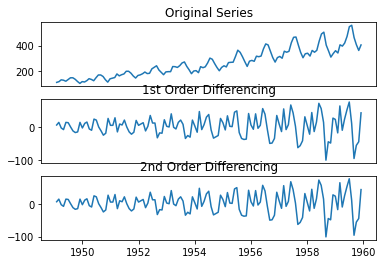

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(train['Thousands of Passengers']);
ax1.set_title('Original Series'); 
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train['Thousands of Passengers'].diff()); 
ax2.set_title('1st Order Differencing'); 
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train['Thousands of Passengers'].diff());
ax3.set_title('2nd Order Differencing')
plt.show()

Above it looks like that both the first order and second order have made the data stationary. So which one do we pick? We look at the autocorrelation function for each of the differenced data. We look at the second term. If the second term of the autocorrelation has gone over to the negative side this indidcates the time series has been over differenced. If you see this refer back to the differncing before that. In our case differencing of 1 should be correct

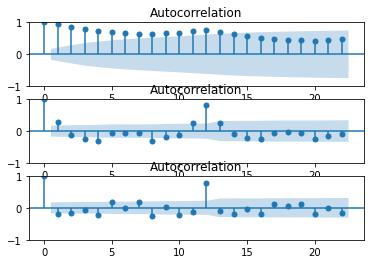

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(train['Thousands of Passengers'], ax=ax1)
plot_acf(train['Thousands of Passengers'].diff().dropna(), ax=ax2)
plot_acf(train['Thousands of Passengers'].diff().diff().dropna(), ax=ax3)
plt.show()

**Step 3: Finding the value of p , the autoregressive order**

We shall use the PACF function in order to get p. This represents the order of previous data points that we want in order to predict the next data point. Lets look at this for our data. Notice how we are applying the pcf to the detrended data.

C:\Users\PeterBaksh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


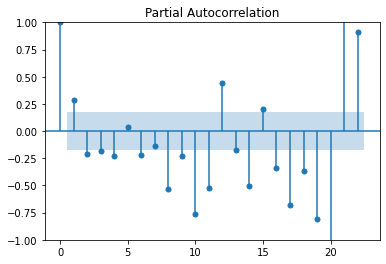

In [18]:
plot_pacf(train['Thousands of Passengers'].diff().dropna())
plt.show()

The first lag term is significant. The second lag term is only just outside the zone of sifnifcance. Given that we can leave it that we shall only include one lag term in our forecast. 

Lets keep track of the terms do far:
d = 1
p = 1

Now for the moving average part, q

**Step 4 : calculating q**

The moving average part of the coefficents can be calculated from the ACF. Our value of q should be equl to the number of points that fall outside the zone of insignificance. However we should be looking at quite significant spikes and ignore the seaosonal spike. 

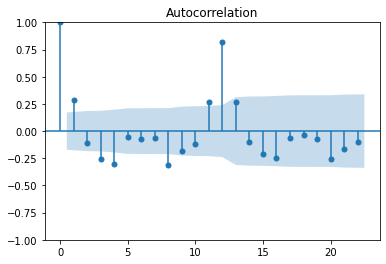

In [19]:
plot_acf(train['Thousands of Passengers'].diff().dropna())
plt.show()

I would suggest a value of 1  2 or 3 here for the value at lag 1 and lag 4 or 8. Lets go with middle ground at a value of 2 spikes

Lets keep track of the terms do far:
d = 1
p = 1
q= 2

**We now fit our ARIMA model to the data we have in train specifying the values for p q and d**

In [20]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Thousands of Passengers'], order = (1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                  132
Model:                      ARIMA(1, 1, 2)   Log Likelihood                -622.487
Date:                     Mon, 03 Apr 2023   AIC                           1252.974
Time:                             11:17:17   BIC                           1264.474
Sample:                         01-01-1949   HQIC                          1257.647
                              - 12-01-1959                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5673      0.105      5.382      0.000       0.361       0.774
ma.L1         -0.3351      0.105     -3.198      0.001      -0.540      -0.130
ma.L2         -0.4825      0.074     -6.529      0.000      -0.627      -0.338
sigma2       781.3644     96.191      8.123      0.000     592.834     969.894
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.80   Prob(JB):                         0.96
Heteroskedasticity (H):               7.09   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**We shall not look to deeply into the summary apart from to note that the AIC can be used as a measure of how well the model fits the data and that the number of coefficients will depend on the settings for the number of moving average and autoregressive components that you included in the model.** 

**We now update our results dataframe to observe the metrics of how the ARIMA forecast performed on this data**

In [21]:
train_fit_arima = model_fit.fittedvalues
test_forecast_arima = model_fit.forecast(steps = len(test))
results = update_results('ARIMA', 'airpassenger',results, train, train_fit_arima, test, test_forecast_arima)
results

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5


**Wow, whilst the training metrics were fine the testing metrics were terrible. Lets view the graph to see what was going on**

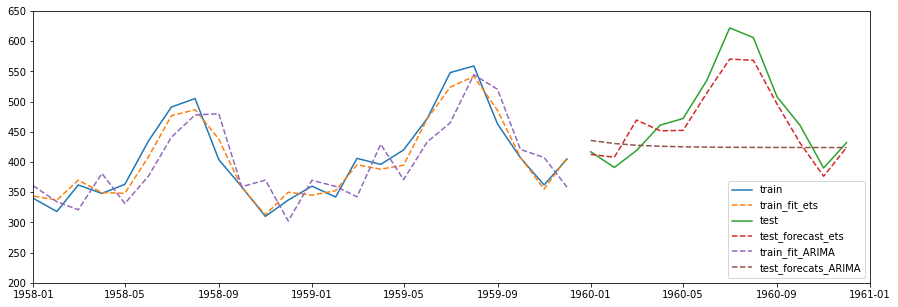

In [22]:
plt.plot(train.index, train['Thousands of Passengers'])
plt.plot(train.index, train_fit_ets, '--')
plt.plot(test.index, test['Thousands of Passengers'])
plt.plot(test.index, test_forecast_ets, '--')
plt.plot(train.index, train_fit_arima, '--')
plt.plot(test.index, test_forecast_arima, '--')
plt.legend(['train', 'train_fit_ets', 'test', 'test_forecast_ets', 'train_fit_ARIMA', 'test_forecats_ARIMA'])
plt.xlim(['1958', '1961'])
plt.ylim([200, 650])
fig = plt.gcf()
fig.set_size_inches(15 ,5)

**Clearly ARIMA is struggling to forecast well without the seasonality component.... This is where SARIMA comes in**

**SARIMA(p,d,q)(P,D,Q)m**

SARIMA is the seasonal version of ARIMA that has 3 more coefficients, P, Q, D , m these are the seasonal specific terms for the SARIMA algorithm.

- p: the order of the autoregressive (AR) term in an ARIMA model, which represents the dependence of the current value on its previous values.
- q: the order of the moving average (MA) term in an ARIMA model, which represents the dependence of the current value on past error terms.
- d: the degree of differencing in an ARIMA model, which transforms the non-stationary time series into a stationary one.
- P: the order of the seasonal AR term in a SARIMA model, which models the seasonal variation of the time series.
- Q: the order of the seasonal MA term in a SARIMA model, which models the seasonal variation of the time series.
- D: the degree of seasonal differencing in a SARIMA model, which transforms the seasonal time series into a stationary one.
- m: the number of time periods in a seasonal cycle, which is used to identify the period of the seasonal variation in the time series.

**To estimate P Q and D we need to repeat the ARIMA steps for only the seasonal component. Therefore we need to extract the seasonal component first. We can use the decompose function to do this which we saw before. lets see it again**

In [23]:
seasonal_decompose(train['Thousands of Passengers'],model='multiplicative')

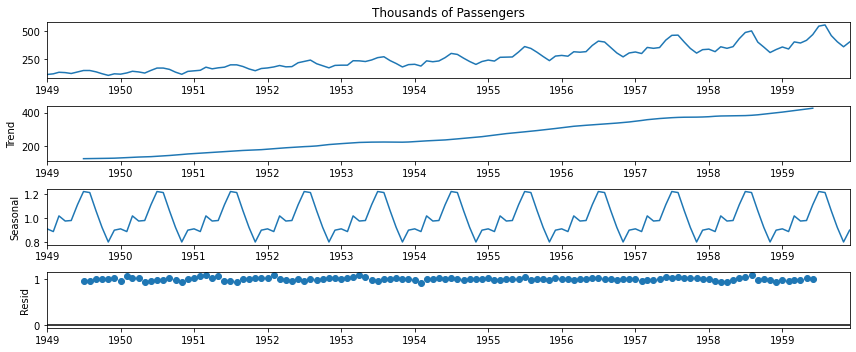

In [24]:
fig = decomp.plot()
fig.set_size_inches((12, 5))
fig.tight_layout()
plt.show();

<AxesSubplot:xlabel='Month'>

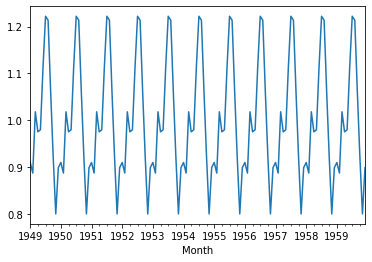

In [25]:
seasonal = decomp.seasonal
seasonal.plot()

Now we have the seasonal component we appy the same steps we did in arima to find p q and d

The time series is stationary here so we can say D = 0

**Selecting Q**

Count the number of lags that are outside the zone of signficance (clearly) of the PCF and the number will be equal to the Q param


C:\Users\PeterBaksh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


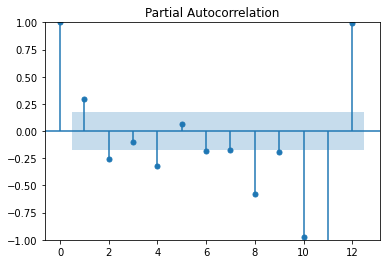

In [26]:
plot_pacf(seasonal.diff().dropna(), lags = 12)
plt.show()

There are 7 values that are greater than the significant zone. Lets therefore let Q =7

**Selecting P**

Count the number of points that are outside of the zone of signifcance and this will equal the value of p

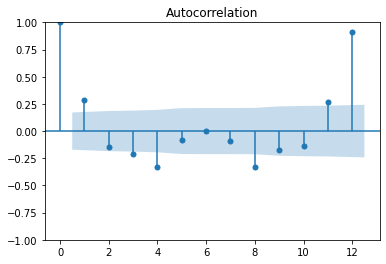

In [27]:
plot_acf(seasonal.diff().dropna(), lags = 12)
plt.show()

Lets use p equal to 4 in this case

**We now fit our SARIMA model using the coefficients for the seasonality**

In [28]:
d = 1; p = 1; q = 2; Q =7; P = 4; D = 0; m = 12
model = sm.tsa.statespace.SARIMAX(train['Thousands of Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()
model_fit.summary()

C:\Users\PeterBaksh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\PeterBaksh\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                               SARIMAX Results                                                
==============================================================================================================
Dep. Variable:                                Thousands of Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(4, 0, [1, 2, 3, 4, 5, 6, 7], 12)   Log Likelihood                -498.140
Date:                                                Mon, 03 Apr 2023   AIC                           1026.281
Time:                                                        11:17:47   BIC                           1069.409
Sample:                                                    01-01-1949   HQIC                          1043.806
                                                         - 12-01-1959                                         
Covariance Type:                                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.088     10.299      0.000       0.732       1.076
ma.L1         -1.1439      0.102    -11.187      0.000      -1.344      -0.944
ma.L2          0.1570      0.098      1.602      0.109      -0.035       0.349
ar.S.L12       0.4609      1.594      0.289      0.772      -2.663       3.585
ar.S.L24       0.2840      1.222      0.232      0.816      -2.112       2.680
ar.S.L36       0.8164      1.379      0.592      0.554      -1.886       3.519
ar.S.L48      -0.6335      1.592     -0.398      0.691      -3.754       2.487
ma.S.L12       0.5256      8.502      0.062      0.951     -16.138      17.189
ma.S.L24       0.3301      5.979      0.055      0.956     -11.389      12.049
ma.S.L36      -0.8319      6.094     -0.137      0.891     -12.776      11.113
ma.S.L48       0.3722      3.988      0.093      0.926      -7.445       8.189
ma.S.L60       0.4092      1.996      0.205      0.838      -3.504       4.322
ma.S.L72       0.7712      9.542      0.081      0.936     -17.931      19.474
ma.S.L84      -0.0868      1.614     -0.054      0.957      -3.251       3.078
sigma2        50.5097    565.818      0.089      0.929   -1058.473    1159.493
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.77   Prob(JB):                         0.15
Heteroskedasticity (H):               2.22   Skew:                            -0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Notice far more coefficients that are there to capture the infomation in the seasonality**

**Hopefully you get the idea of what is going on below now. We extract the fitted datapoints, the predictions, analyse them and store them. We then view the plots**

In [29]:
train_fit_sarima = model_fit.fittedvalues
test_forecast_sarima = model_fit.forecast(steps = len(test))
results = update_results('SARIMA', 'airpassenger',results, train, train_fit_sarima, test, test_forecast_sarima)
results


,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96


**SARIMA looks like an improvement on the ETS algorithm**

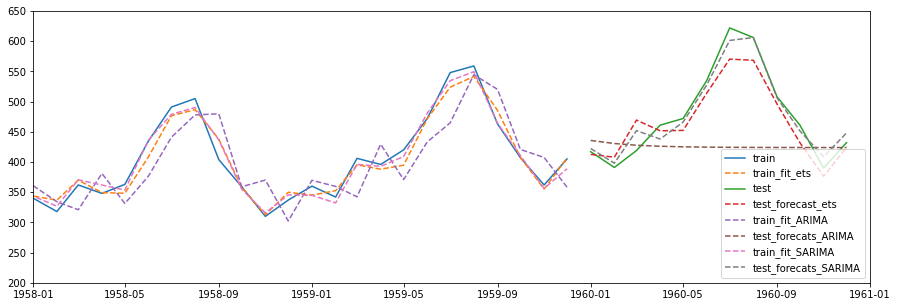

In [30]:
plt.plot(train.index, train['Thousands of Passengers'])
plt.plot(train.index, train_fit_ets, '--')
plt.plot(test.index, test['Thousands of Passengers'])
plt.plot(test.index, test_forecast_ets, '--')
plt.plot(train.index, train_fit_arima, '--')
plt.plot(test.index, test_forecast_arima, '--')
plt.plot(train.index, train_fit_sarima, '--')
plt.plot(test.index, test_forecast_sarima, '--')
plt.legend(['train', 'train_fit_ets', 'test', 'test_forecast_ets', 'train_fit_ARIMA', 'test_forecats_ARIMA',
            'train_fit_SARIMA', 'test_forecats_SARIMA'])
plt.xlim([pd.to_datetime('1958-01-01'), pd.to_datetime('1961')])
plt.ylim([200, 650])
fig = plt.gcf()
fig.set_size_inches(15 ,5)

**How important are setting the SARIMA Parameters?**

The parameters do effect how the model performs however we have only estimated them. For example lets see the effect when we use seasonal params as Q and P equal to 1 instead. 



In [31]:
Q =1; P = 1; D = 0; m = 12
model = sm.tsa.statespace.SARIMAX(train['Thousands of Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()
model_fit.summary()
train_fit_sarima = model_fit.fittedvalues
test_forecast_sarima = model_fit.forecast(steps = len(test))
results = update_results('SARIMA- PQ=1', 'airpassenger',results, train, train_fit_sarima, test, test_forecast_sarima)
results

C:\Users\PeterBaksh\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94


**Notice we get a slight reduction in the test however the training and testing rmse were worse. In practise we would reccomend that you run a Grid search of a range of values for all your paramters especially p q an P Q. The easiest way to do this would be to run nested for loops cycling through the parameters that you want to try**

<div class="alert alert-block alert-warning">
<b>Extension </b>
Try this for youself now in the exericse notebook [ Time permitting during WS] 
<br>
</div>

# Regression Forecasting for More Complicated Time Series

ETS and SARIMA model implimentations may struggle when dealing with multiple seasonality. ETS cannot accept multiple seasonal periods , whilst it can detect them it is then prone to overfitting too many seasonal periods. Feel free to try this setting the ETS Seasonal period parameter to None ( we shall use this as a baseline model briefly in our analysis later on).  Alterantively you could manually make many ETS models and combine them to prevent overfitting however this is hard work.  Whilst in theory SARIMA can deal with multiple seasonality in Python in stats models it can't be done with current packages (as far as I am aware). This poses a limitation for time series that have multiple seasonal periods occuring. Furthermore whilst SARIMAMAX can deal with **exogenous** variables (variables that may influence the time series) regression can also do this, and the regresison algorithm will also likely run far quicker. 

So lets look at the dataset and get into time series forecasting using Regression

In [32]:
X = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/temperature_load.csv?raw=true')[['date_time', 'total load actual', 'temp_mean']]
X.date_time = pd.to_datetime(X.date_time)
X.head()

,date_time,total load actual,temp_mean
0,2015-01-01 00:00:00,25385.0,270.475
1,2015-01-01 01:00:00,24382.0,270.475
2,2015-01-01 02:00:00,22734.0,269.686
3,2015-01-01 03:00:00,21286.0,269.686
4,2015-01-01 04:00:00,20264.0,269.686


**View the data**

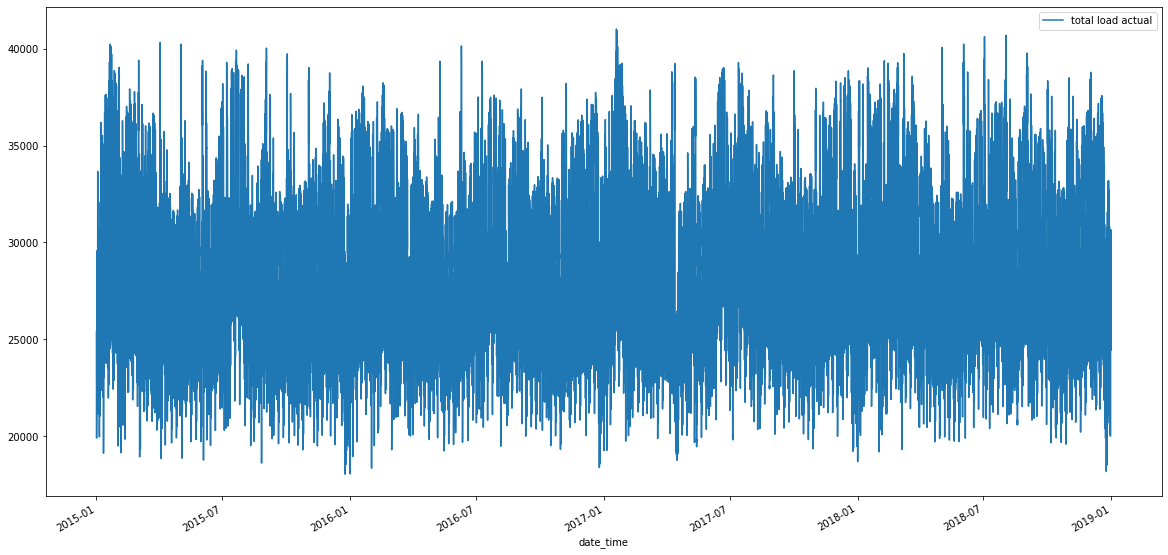

In [33]:
X.set_index('date_time').plot(y = 'total load actual')
fig = plt.gcf()
fig.set_size_inches(20, 10)

**The above data was over a long period we could not see what was going on at the day / hour level. We zoom in below**

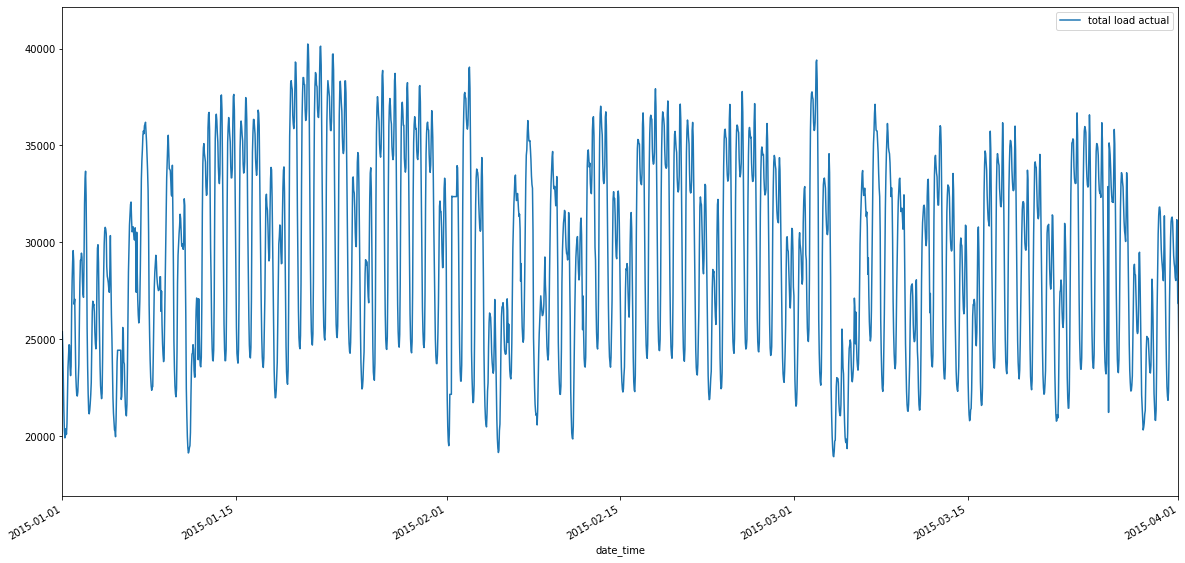

In [34]:
X.set_index('date_time').plot(y = 'total load actual')
plt.xlim(['2015-01-01', '2015-04-01'])
fig = plt.gcf()
fig.set_size_inches(20, 10)

**Regression and FB Prophet deal with missing values fine. However ETS and ARIMA do not. It is worth checking and dealing with these missing values if we want to compare models**

In [35]:
X = X.set_index('date_time')

**Running the cell below should give an error**

In [36]:
# X.index.freq = 'H'

**We can get a better ideas as to what dates are missing by comparing hourly data between two dates with the dates that are in our dataset**

In [37]:
gaps = pd.date_range(start=min(X.index), 
                     end=max(X.index),
                     freq='H').difference(X.index)
gaps

DatetimeIndex(['2015-03-29 02:00:00', '2016-03-27 02:00:00',
               '2017-03-26 02:00:00', '2018-03-25 02:00:00'],
              dtype='datetime64[ns]', freq=None)

**This is probably been caused by the change in time / daylight savings. I suspect we have duplicate values on this time stamp and then missing values where the duplicate was created**

**If we having missing values over some dates U suspect we should have duplicate values on other dates. Lets test this**

In [38]:
X.index.to_frame().duplicated().sum()

4

**4 duplicate values. Lets just keep one of these values for each duplicate**

In [39]:
X = X[~X.index.to_frame().duplicated()]

**Now lets deal with the missing data**

We should impute these missing values. We are first going to create a complete set of dates. We will then merge these clean dates with the exisiting table using a left join. This will leave missing values in this dataframe. We shall then fill these missing values using backfill

In [40]:
cleaned_date = pd.date_range(start=min(X.index), 
                     end=max(X.index),
                     freq='H')
X_cleaned = pd.DataFrame(cleaned_date, columns = ['date_time'])
cleaned_date.shape, X.shape

((35064,), (35060, 2))

**Notice how the cleaned data has 4 more rows than the original data**

In [41]:
X_cleaned = X_cleaned.merge(X, how = 'left', on= 'date_time')
X_cleaned.set_index('date_time', inplace = True)
X_cleaned = X_cleaned.fillna(method='bfill')
X_cleaned.index.freq = 'H'

In [42]:
X_cleaned.isna().sum()

total load actual    0
temp_mean            0
dtype: int64



## <a id='6'> **Extra (Not for Workshop) : Identifying Multiple Seasonality** </a>
### Move onto Building Regression Model
<div class="alert alert-block alert-success">
- As we saw from the initial data this data contains  multiple seasonalities. 
- In order to uncover each seasonal period we shall look at the acf at different levels of granularity
- Below we perform the acf on our target , the total actual load, which we note the frequency is in hours. The acf and pacf can help us identify seasonality

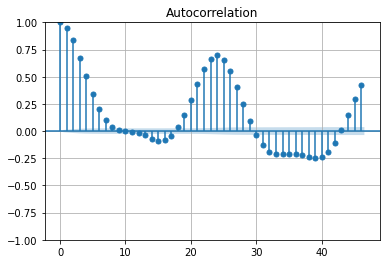

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(X_cleaned['total load actual'])
plt.grid('minor')
plt.show()


**We observe that there is a strong spike at 24 hours which indicates 24 hour seasonality**

We can pull out this 24 hour seasonality from the time series using the decomposition function as shown below. Notice when we plot the trend there is still lots of structure in there. This likely represents the other seasonalities in the time series

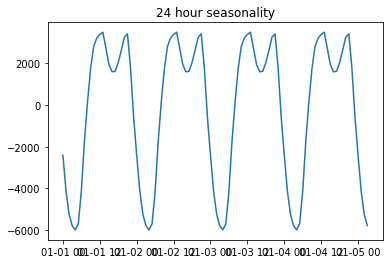

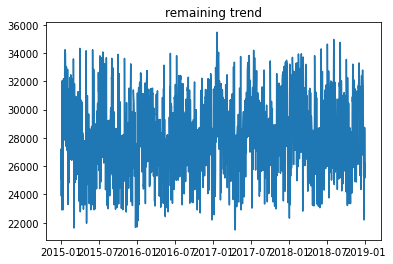

In [44]:
decomp= sm.tsa.seasonal_decompose(X_cleaned['total load actual'], period=24, model='add')
plt.plot(decomp.seasonal[0:100])
plt.title('24 hour seasonality')
plt.show()
plt.plot(decomp.trend)
plt.title('remaining trend')
plt.show()



We now want to uncover if there is seasonality at the next level up in time, so we subtract the 24 hour seasonality from the original time series as shown below. We shall also re sample the data to the day level at this point




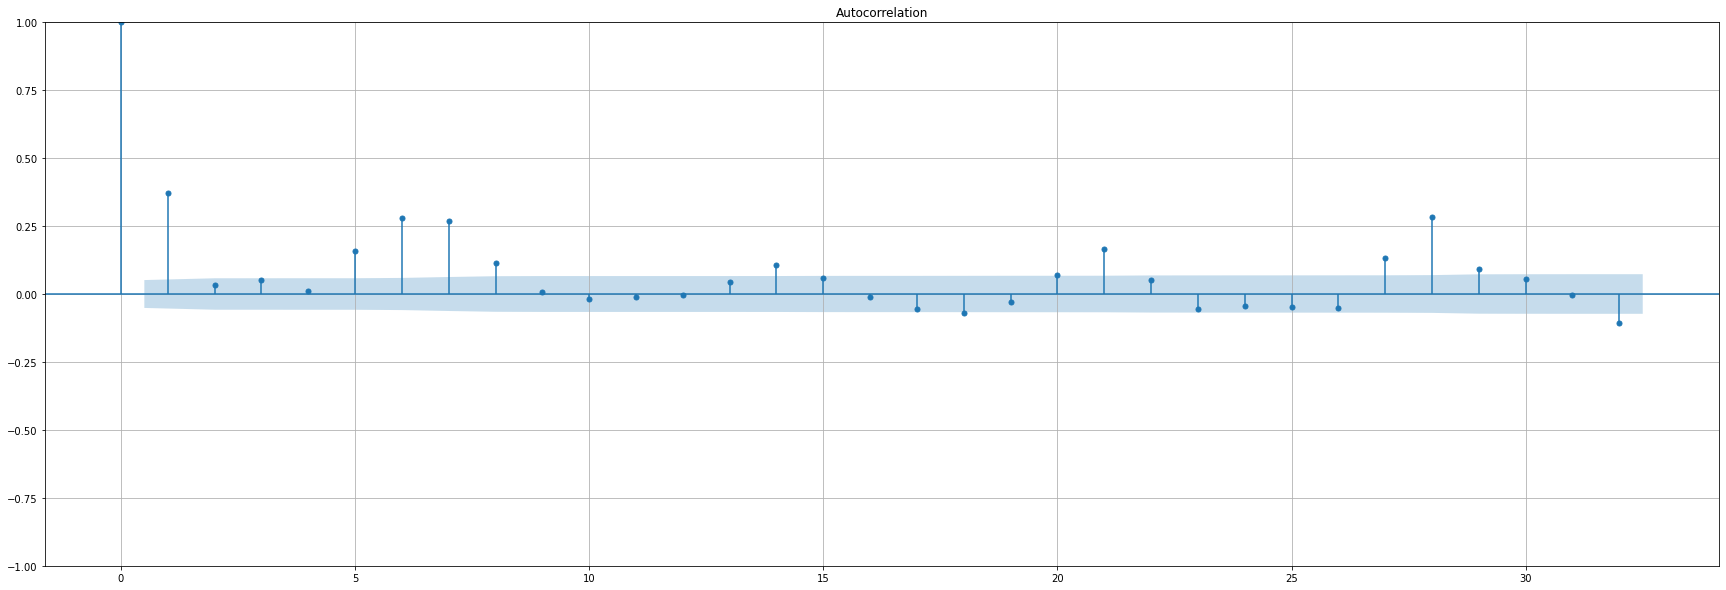

In [45]:
deseasoned_1 = X_cleaned['total load actual'] - decomp.seasonal



acf = plot_acf(deseasoned_1.resample('D').mean())
plt.grid(True)
fig = plt.gcf()
fig.set_size_inches(30, 10)
plt.show()

**We observe that the autocorrelation seems to peak at between 6 and 7 days which indicates a repeating pattern every week **. Now we can decompose the time series by the week and investigate that for patterns

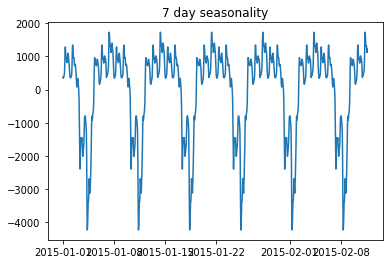

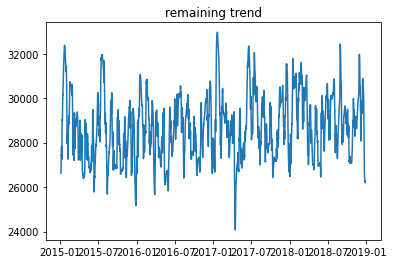

In [46]:
decomp= sm.tsa.seasonal_decompose(deseasoned_1, period=int(24 * 7), model='add')
plt.plot(decomp.seasonal[0:1000])
plt.title('7 day seasonality')
plt.show()
plt.plot(decomp.trend)
plt.title('remaining trend')
plt.show()

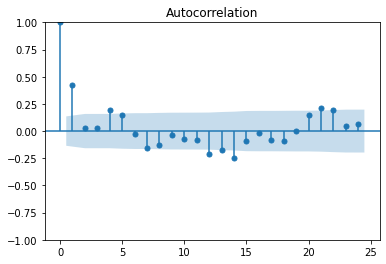

In [47]:
deseasoned_2 = deseasoned_1 - decomp.seasonal
week = deseasoned_2.resample('W').mean()
acf = plot_acf(week)
plt.show()

**It does not look like there is anything too significant in seasonality week to week** . Lets group by Month and see if there is seasonality there

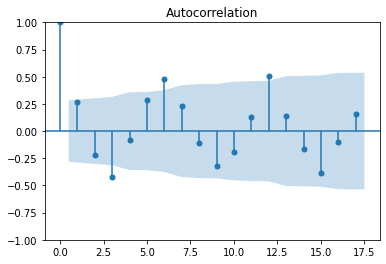

In [48]:
month = deseasoned_2.resample('M').mean()
acf = plot_acf(month)
plt.show()

We see repeating patterns every 6 months and every 12. 6 I find suprising, however 12 makes sense given the seasonal effect one would expect on energy load

So finally lets pull out this monthly seasonality based on 365*24 periods 

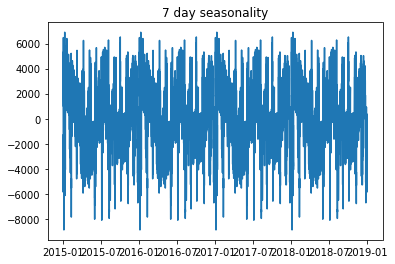

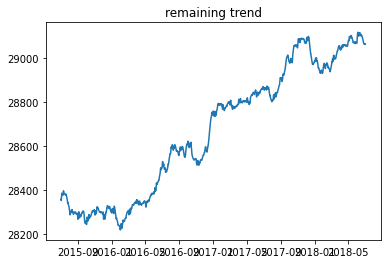

In [49]:
decomp= sm.tsa.seasonal_decompose(deseasoned_2, period=int(24 * 365), model='add')
plt.plot(decomp.seasonal)
plt.title('7 day seasonality')
plt.show()
plt.plot(decomp.trend)
plt.title('remaining trend')
plt.show()


## <a id='6'> **Building Regression Model** </a>

**Just before we do our regresison model lets extract a baseline model using ETS*
- The code below first splits our data into training and testing data and then we fit an ets model
- ETS does not allow us to set seasonal periods manually. If we set the seasonal periods to None then ETS tries to fit the best periods for us 

**First lets create a train test split for our new data suitable for ets**

In [50]:
thresh = 0.95 #  95 % of the data used for training

train= X_cleaned.iloc[:int(len(X) * thresh), :]
test= X_cleaned.iloc[int(len(X) * thresh):, :]

In [51]:
model = sm.tsa.ETSModel(train['total load actual'] ,error='mul', trend=None, seasonal='mul', seasonal_periods=None).fit()

train_fit_ets_2 = model.fittedvalues
test_forecast_ets_2 = model.forecast(steps = len(test))
results = update_results('ETS', 'energy',results, train.iloc[:, 0], train_fit_ets_2, test.iloc[:,0], test_forecast_ets_2)
results.head()



,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36


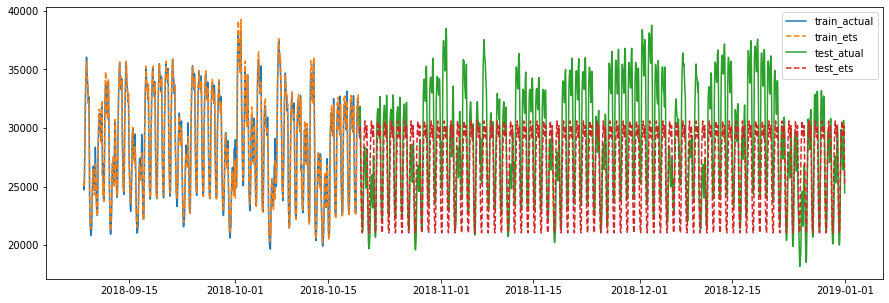

In [52]:
plt.plot(train.index[-1000:], train['total load actual'][-1000:])
plt.plot(train.index[-1000:], train_fit_ets_2[-1000:], '--')
plt.plot(test.index, test['total load actual'])
plt.plot(test.index, test_forecast_ets_2, '--')
plt.legend(['train_actual', 'train_ets', 'test_atual', 'test_ets'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)



**The ETS algorithm has horribly overfit the training data. My guess is that since we could not force seasonality since we cannot in the settings it has auto detected far too many seasonal periods. Below we can see i detected 24 periods, which explains why it overfit so badly. However in the interest of time lets move swifty onto regression**

In [53]:
# model.param_names

### Regression Recap

In regression we are trying to find a model to predict a dependent variable (in our case total actual load) from one or more independant variables. 

### What could be influencing our actual load

- In our dataset we have the **temperature**. This could be. When considering your problem features external to the time series could definitly be used as a factor to help predict your time series
- Time of day : We are seeing fluctuations within a **24 hour period**. This is telling us we need to include time of day in a regression forecast
- Day of the week: There looks to be fluctuations in demand depending on the **day of the week**. If this is the case we need to include this as a feature in our predictin
- Month of the year : Does the data look to be changing depending on Month? It looks like it is. If we are unsure we can group the data by month and have a look at this?
- Year : Is the data changing year by year. If it is this needs to be a feature that we can include in our regression analysis. 

##### Other variables to consider
- lag variables : These are variables that we can create based on, in this case, averages of the load over a period prior to the forecast. These can sometimes be influencial in forecasting
- Holiday specific dates : National holidays  are good candidates for these. Depending on the problem there could be other dates around the year that could be included in a regression analysis. For example prediciting holiday bookings will not just be dependant on the seasonal date however there will be a large influence on the school holidays. Having a column that lets the algorithm know if this date is a school holiday or not is likely to improve your forecast signficantly. 

## Prepare the data for regression

- We must prepare the data in the same way we prepared data for regression earlier on in the course. So lets immediately split our data, **not randomly but by time again.**
- We can seel below total load actual will become our target and temp_mean will become an exogenous variable


In [54]:
X_cleaned.head(2)

,total load actual,temp_mean
date_time,,
2015-01-01 00:00:00,25385.0,270.475
2015-01-01 01:00:00,24382.0,270.475


In [55]:
y = X_cleaned['total load actual']
X = X_cleaned.iloc[:, [1]]
X_train = X_cleaned.iloc[:int(len(X) * thresh), :]
X_test = X_cleaned.iloc[int(len(X) * thresh):, :]
X_train.drop(columns = ['total load actual'], inplace = True)
X_test.drop(columns = ['total load actual'], inplace = True)
y_train = y[:int(len(X) * thresh)]
y_test = y[int(len(X) * thresh):]

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\3766514658.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns = ['total load actual'], inplace = True)
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\3766514658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns = ['total load actual'], inplace = True)


**Lets visualise what section of our data will be used for both training and for testing**

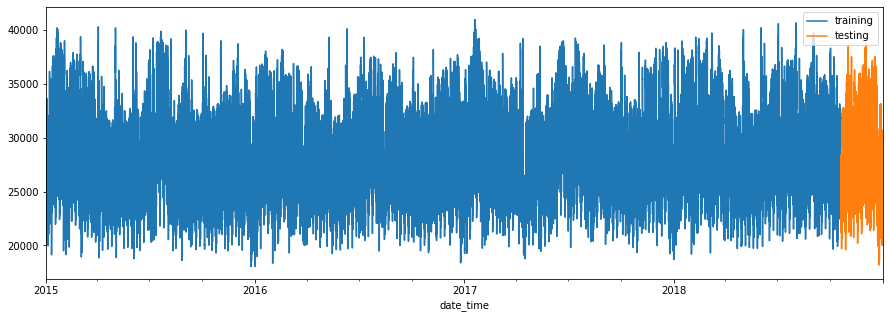

In [56]:
fig = plt.figure(figsize=(15, 5))
y_train.plot(y = 'load')
y_test.plot(y = 'load')
plt.legend(['training', 'testing'])

**Lets explore whats currently in X_train**

In [57]:
X_train.head()

,temp_mean
date_time,
2015-01-01 00:00:00,270.475
2015-01-01 01:00:00,270.475
2015-01-01 02:00:00,269.686
2015-01-01 03:00:00,269.686
2015-01-01 04:00:00,269.686


## Generating our time features
- At the moment regression algorithms cannot work with a timestamp, they require an integer or a float. Therefore we need to break down datetime into its components. Note here you could also be introducing lag variables

In [58]:
X_train['year'] = [X_train.index[i].year for i in range(len(X_train))]
X_train['month'] = [X_train.index[i].month for i in range(len(X_train))]
X_train['time'] = [int(str(X_train.index[i].time())[0:2]) for i in range(len(X_train))]
X_train['dayofweek'] = [X_train.index[i].weekday() for i in range(len(X_train))]
X_train['weekend'] = np.where(X_train['dayofweek'].isin([5, 6]), 1, 0)
X_train.head()

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\343510581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['year'] = [X_train.index[i].year for i in range(len(X_train))]
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\343510581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['month'] = [X_train.index[i].month for i in range(len(X_train))]
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\343510581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,temp_mean,year,month,time,dayofweek,weekend
date_time,,,,,,
2015-01-01 00:00:00,270.475,2015,1,0,3,0
2015-01-01 01:00:00,270.475,2015,1,1,3,0
2015-01-01 02:00:00,269.686,2015,1,2,3,0
2015-01-01 03:00:00,269.686,2015,1,3,3,0
2015-01-01 04:00:00,269.686,2015,1,4,3,0


**Repeat for the testing data so we have the same features**

In [59]:
X_test['year'] = [X_test.index[i].year for i in range(len(X_test))]
X_test['month'] = [X_test.index[i].month for i in range(len(X_test))]
X_test['time'] = [int(str(X_test.index[i].time())[0:2]) for i in range(len(X_test))]
X_test['dayofweek'] = [X_test.index[i].weekday() for i in range(len(X_test))]
X_test['weekend'] = np.where(X_test['dayofweek'].isin([5, 6]), 1, 0)
X_test.head()

C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\2307637814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['year'] = [X_test.index[i].year for i in range(len(X_test))]
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\2307637814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['month'] = [X_test.index[i].month for i in range(len(X_test))]
C:\Users\PeterBaksh\AppData\Local\Temp\ipykernel_27488\2307637814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,temp_mean,year,month,time,dayofweek,weekend
date_time,,,,,,
2018-10-19 22:00:00,292.15,2018,10,22,4,0
2018-10-19 23:00:00,292.15,2018,10,23,4,0
2018-10-20 00:00:00,292.15,2018,10,0,5,1
2018-10-20 01:00:00,292.15,2018,10,1,5,1
2018-10-20 02:00:00,292.15,2018,10,2,5,1


## EDA from our regression variables 

Lets quickly graph some of variables to get a better picture of what is going on in this case.

**Lets look at our only exogenous variable and see how that correlates with our total actual load**

C:\Users\PeterBaksh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


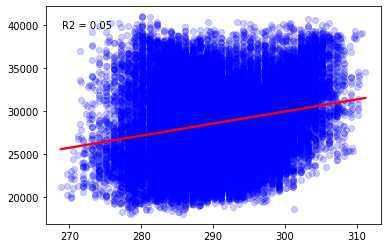

In [60]:
sns.regplot(X_train.temp_mean.values, y_train.values, color='red', scatter_kws={'color': 'blue', 'alpha': 0.2})
slope, intercept, r_value, p_value, std_err = stats.linregress(X_train.temp_mean.values, y_train.values)
r_squared = r_value ** 2
plt.annotate(f'R2 = {r_squared:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.show()

A very weak positive correlation observed with a small R2.

**Now lets look at our time components and see how they look to effect the load**

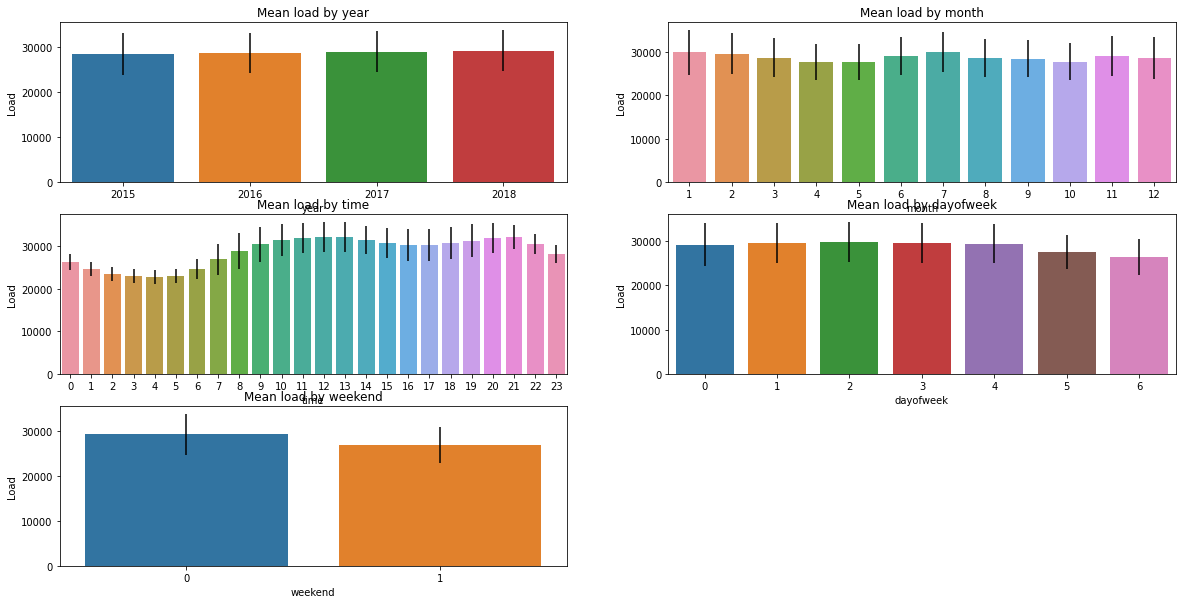

In [61]:
import copy
columns = ['year', 'month', 'time', 'dayofweek', 'weekend']
train_dataset = copy.deepcopy(X_train)
train_dataset['target'] = y_train

# Iterate over columns and create bar plot with error bars for each
for plot_count, col in enumerate(columns):
    # Calculate mean and std for unique values in column
    col_mean = train_dataset.groupby(col)['target'].mean()
    col_std = train_dataset.groupby(col)['target'].std()
    plt.subplot(3,2,plot_count + 1)
    # Create bar plot with error bars
    sns.barplot(x=col_mean.index, y=col_mean.values, yerr=col_std.values)

    # Add title and axis labels
    plt.title(f'Mean load by {col}')
    plt.xlabel(col)
    plt.ylabel('Load')

    # Show plot
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

## Regression Model 1: Linear regression

## Training with Date Time Components Only - to compare with ETS

In [62]:
train_temp = X_train.temp_mean # we shall add it on later
X_train = X_train.drop(columns = ['temp_mean'])
test_temp = X_test.temp_mean # we shall add it on later
X_test = X_test.drop(columns = ['temp_mean'])
X_train.head(2)

,year,month,time,dayofweek,weekend
date_time,,,,,
2015-01-01 00:00:00,2015,1,0,3,0
2015-01-01 01:00:00,2015,1,1,3,0


In [63]:
model = sm.OLS(y_train, sm.add_constant(X_train.values),missing='raise').fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total load actual   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     3733.
Date:                Mon, 03 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:18:33   Log-Likelihood:            -3.2055e+05
No. Observations:               33310   AIC:                         6.411e+05
Df Residuals:                   33304   BIC:                         6.412e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.504e+05   3.73e+04    -12.092      0.000   -5.23e+05   -3.77e+05
x1           236.1137     18.473     12.782      0.000     199.907     272.321
x2           -57.5440      6.009     -9.576      0.000     -69.322     -45.766
x3           357.4901      2.895    123.492      0.000     351.816     363.164
x4            -9.7798     16.354     -0.598      0.550     -41.834      22.274
x5         -2446.5142     72.388    -33.797      0.000   -2588.397   -2304.632
==============================================================================
Omnibus:                      467.757   Durbin-Watson:                   0.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.640
Skew:                           0.212   Prob(JB):                     2.24e-88
Kurtosis:                       2.668   Cond. No.                     3.75e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**The model fit shows an R2 of 0.36 which is not bad. Lets compute metrics for both the test and train data like we did previously**


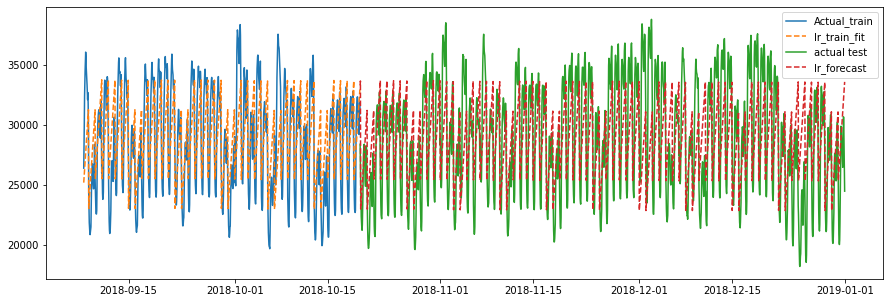

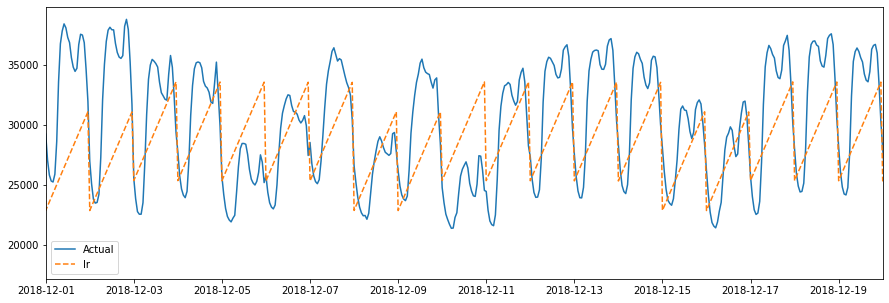

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38


In [64]:
train_fit_lr = model.predict(sm.add_constant(X_train))
test_forecast_lr =  model.predict(sm.add_constant(X_test, has_constant = 'add'))
results = update_results('LR', 'energy',results, y_train, train_fit_lr, y_test, test_forecast_lr)
results

plt.plot(y_train.index[-1000:], y_train[-1000:])
plt.plot(y_train.index[-1000:], train_fit_lr[-1000:], '--')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.legend(['Actual_train', 'lr_train_fit', 'actual test', 'lr_forecast'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.xlim([pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-20')])
plt.legend(['Actual', 'lr'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

results.head(10)


**Notice the linear behaviour in hour. The linear model cant fit to the data the way we have presented the data to it. The linear model can only fit linear trends, unless we one hot encode these columns. Lets see the effect of this now**

In [65]:

from sklearn.preprocessing import OneHotEncoder

columns_to_encode = ['month', 'time', 'dayofweek']

encoder = OneHotEncoder(categories='auto', sparse=False, drop='first').fit(X_train[columns_to_encode])

# Transform the training and test data
X_train_encoded = pd.DataFrame(encoder.transform(X_train[columns_to_encode]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[columns_to_encode]))

# Rename the columns in the encoded DataFrames
X_train_encoded.columns = encoder.get_feature_names(columns_to_encode)
X_test_encoded.columns = encoder.get_feature_names(columns_to_encode)

# Print the first few rows of the encoded DataFrames
X_train_encoded = pd.concat([X_train.loc[:, ['year', 'weekend']].reset_index(drop = True), X_train_encoded.reset_index(drop = True)],axis = 1)
X_test_encoded = pd.concat([X_test.loc[:, ['year', 'weekend']].reset_index(drop = True), X_test_encoded.reset_index(drop = True)], axis = 1)

C:\Users\PeterBaksh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\PeterBaksh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
X_train_encoded.head()

,year,weekend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,time_20,time_21,time_22,time_23,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
0,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2015,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**Notice the shape difference between encoded dataframe and our original dataframe**

In [67]:
X_test.shape, X_train.shape

((1754, 5), (33310, 5))

In [68]:
model = sm.OLS(y_train, sm.add_constant(X_train_encoded.values),missing='raise').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total load actual   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1395.
Date:                Mon, 03 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:18:34   Log-Likelihood:            -3.1130e+05
No. Observations:               33310   AIC:                         6.227e+05
Df Residuals:                   33268   BIC:                         6.230e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.861e+05   2.84e+04    -17.108      0.000   -5.42e+05    -4.3e+05
x1           254.8358     14.090     18.086      0.000     227.219     282.453
x2         -1430.5876     32.832    -43.573      0.000   -1494.939   -1366.236
x3          -314.3781     73.577     -4.273      0.000    -458.592    -170.165
x4         -1222.5534     71.854    -17.014      0.000   -1363.389   -1081.717
x5         -2181.0647     72.447    -30.106      0.000   -2323.063   -2039.066
x6         -2149.7237     71.851    -29.919      0.000   -2290.554   -2008.894
x7          -859.1899     72.448    -11.859      0.000   -1001.191    -717.188
x8           157.9210     71.849      2.198      0.028      17.094     298.748
x9         -1266.9731     71.854    -17.633      0.000   -1407.809   -1126.137
x10        -1476.5219     72.447    -20.381      0.000   -1618.521   -1334.523
x11        -2061.1527     73.798    -27.930      0.000   -2205.800   -1916.506
x12         -695.3058     78.664     -8.839      0.000    -849.489    -541.123
x13        -1148.3008     77.929    -14.735      0.000   -1301.045    -995.556
x14        -1694.9287    105.205    -16.111      0.000   -1901.134   -1488.723
x15        -2825.6484    105.205    -26.859      0.000   -3031.854   -2619.443
x16        -3368.4236    105.205    -32.018      0.000   -3574.629   -3162.218
x17        -3581.8156    105.205    -34.046      0.000   -3788.021   -3375.610
x18        -3292.5850    105.205    -31.297      0.000   -3498.790   -3086.380
x19        -1739.2839    105.205    -16.532      0.000   -1945.489   -1533.079
x20          620.3624    105.205      5.897      0.000     414.157     826.568
x21         2493.8703    105.205     23.705      0.000    2287.665    2700.076
x22         4084.2421    105.205     38.822      0.000    3878.037    4290.447
x23         5160.2601    105.205     49.050      0.000    4954.055    5366.465
x24         5571.1001    105.205     52.955      0.000    5364.895    5777.305
x25         5759.6095    105.205     54.747      0.000    5553.404    5965.815
x26         5873.0483    105.205     55.825      0.000    5666.843    6079.254
x27         5101.4445    105.205     48.491      0.000    4895.239    5307.650
x28         4314.9705    105.205     41.015      0.000    4108.765    4521.176
x29         3982.5454    105.205     37.855      0.000    3776.340    4188.751
x30         3994.7089    105.205     37.971      0.000    3788.504    4200.914
x31         4374.0598    105.205     41.577      0.000    4167.854    4580.265
x32         4958.7197    105.205     47.134      0.000    4752.514    5164.925
x33         5588.6592    105.205     53.122      0.000    5382.454    5794.865
x34         5780.7450    105.205     54.947      0.000    5574.540    5986.950
x35         4165.0361    105.224     39.583      0.000    3958.794    4371.279
x3

**Wow - looks like a big improvement in the model fit. Lets see how it performs on the testing data**

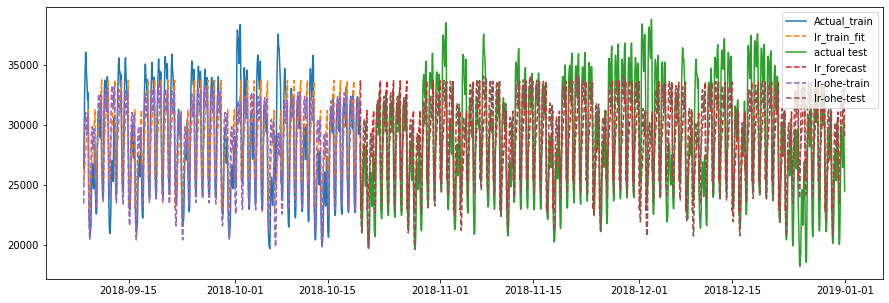

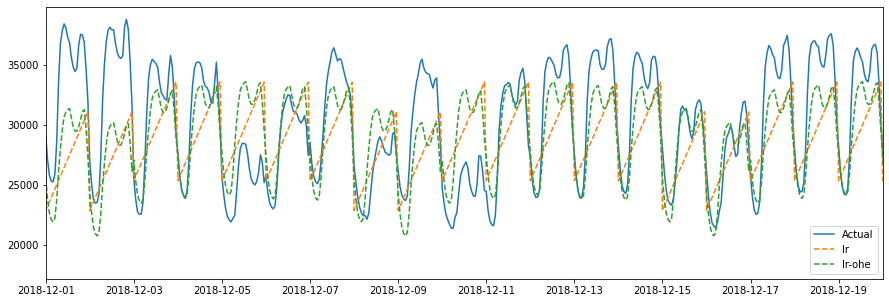

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67


In [69]:
train_fit_lr_2 = model.predict(sm.add_constant(X_train_encoded))
test_forecast_lr_2 =  model.predict(sm.add_constant(X_test_encoded, has_constant = 'add'))
results = update_results('LR-OHE', 'energy',results, y_train, train_fit_lr_2, y_test, test_forecast_lr_2)
results

plt.plot(y_train.index[-1000:], y_train[-1000:])
plt.plot(y_train.index[-1000:], train_fit_lr[-1000:], '--')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.plot(y_train.index[-1000:], train_fit_lr_2[-1000:], '--')
plt.plot(y_test.index, test_forecast_lr_2, '--')
plt.legend(['Actual_train', 'lr_train_fit', 'actual test', 'lr_forecast', 'lr-ohe-train', 'lr-ohe-test'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.plot(y_test.index, test_forecast_lr_2, '--')
plt.xlim([pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-20')])
plt.legend(['Actual', 'lr', 'lr-ohe'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

results


**Almost twice as good !**

Lets now demonstrate how we can now try an alternaitve regression algorithm to see if we can get imporved results

##  <a id='1'> **Improvement using XGBoost** </a>

*XGBoost (eXtreme Gradient Boosting) is a powerful and popular machine learning algorithm used for regression and classification problems. It is an implementation of gradient boosting framework. Gradient boosting is an ensemble method that combines multiple weak models, typically decision trees, to create a stronger model. XGBoost improves upon the traditional gradient boosting algorithm by using a more regularized model formalization to control over-fitting, which gives it better performance.The algorithm works by iteratively training decision tree models on the negative gradient of the loss function of the previous iteration. The decision tree models are trained using the gradient descent algorithm. The final model is a weighted sum of all the decision tree models.The algorithm also includes a built-in regularization term, which helps to reduce overfitting and improve generalization. This is done by introducing a penalty term for the number of terminal nodes in the trees, which is controlled by a parameter called "gamma".Additionally, XGBoost includes several other features such as parallel processing, handling missing values, built-in cross-validation, and handling categorical variables. It is widely used in many Kaggle competitions and industry applications because of its high performance, speed and scalability.*

Resources about XGBoost regressor
- https://xgboost.readthedocs.io/en/stable/python/python_intro.html
- https://www.youtube.com/watch?v=OtD8wVaFm6E

In [70]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train_encoded, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [71]:
train_fit_xgb = model.predict(X_train_encoded)
test_forecast_xgb =  model.predict(X_test_encoded)
results = update_results('xgb-OHE', 'energy',results, y_train, train_fit_xgb, y_test, test_forecast_xgb)
results

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67
0,xgb-OHE,energy,2588.74,7.0,0.68,2834.16,7.0,0.64


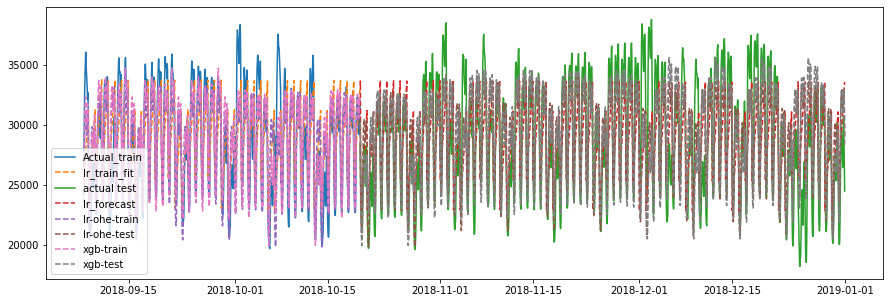

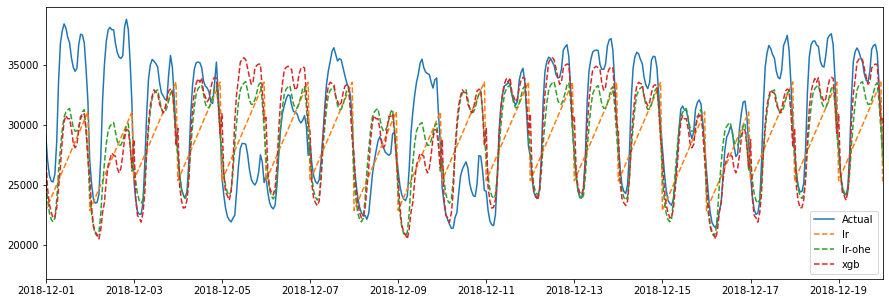

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67
0,xgb-OHE,energy,2588.74,7.0,0.68,2834.16,7.0,0.64


In [72]:
plt.plot(y_train.index[-1000:], y_train[-1000:])
plt.plot(y_train.index[-1000:], train_fit_lr[-1000:], '--')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.plot(y_train.index[-1000:], train_fit_lr_2[-1000:], '--')
plt.plot(y_test.index, test_forecast_lr_2, '--')
plt.plot(y_train.index[-1000:], train_fit_xgb[-1000:], '--')
plt.plot(y_test.index, test_forecast_xgb, '--')
plt.legend(['Actual_train', 'lr_train_fit', 'actual test', 'lr_forecast', 'lr-ohe-train', 'lr-ohe-test', 'xgb-train', 'xgb-test'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.plot(y_test.index, test_forecast_lr_2, '--')
plt.plot(y_test.index, test_forecast_xgb, '--')
plt.xlim([pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-20')])
plt.legend(['Actual', 'lr', 'lr-ohe', 'xgb'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

results

**XgBoost is often a high performing non linear algorithm however in this case LR appears to be performing better on test data**






<div class="alert alert-block alert-success">
<b>Hyper Param Tuning</b> <ul>

Xgboost has more parameters we can tune. Lets try hyper parameter tuning XGboost to get an imporvement in performance... maybe. 

This step can take a while so for the workshop we may leave it out
    
</ol></div> 

In [73]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 500, 1000],
#     'gamma': [0, 0.1, 0.5]}
# #     'subsample': [0.5, 0.7, 0.9],
# #     'colsample_bytree': [0.5, 0.7, 0.9],
# #     'reg_alpha': [0, 0.1, 1],
# #     'reg_lambda': [0, 0.1, 1]
# # }

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=1
# )

# grid_search.fit(X_train_encoded, y_train)

# print("Best hyperparameters:", grid_search.best_params_)


# y_pred = grid_search.best_estimator_.predict(X_test_encoded)



<div class="alert alert-block alert-success">
<b>Skip if tuning not run</b> <ul>

We now take the best fitting mode and apply it to our test data and record our metrics
    
</ol></div> 

In [74]:
# train_fit_xgb_h = grid_search.best_estimator_.predict(X_train_encoded)
# test_forecast_xgb_h =  grid_search.best_estimator_.predict(X_test_encoded)
# results = update_results('xgb_hyper_param-OHE', 'energy',results, y_train, train_fit_xgb, y_test, test_forecast_xgb)
# results

In [75]:
# plt.plot(y_train.index[-1000:], y_train[-1000:])
# plt.plot(y_train.index[-1000:], train_fit_lr[-1000:], '--')
# plt.plot(y_test.index, y_test)
# plt.plot(y_test.index, test_forecast_lr, '--')
# plt.plot(y_train.index[-1000:], train_fit_lr_2[-1000:], '--')
# plt.plot(y_test.index, test_forecast_lr_2, '--')
# plt.plot(y_train.index[-1000:], train_fit_xgb[-1000:], '--')
# plt.plot(y_test.index, test_forecast_xgb, '--')
# plt.plot(y_train.index[-1000:], train_fit_xgb_h[-1000:], '--')
# plt.plot(y_test.index, test_forecast_xgb_h, '--')
# plt.legend(['Actual_train', 'lr_train_fit', 'actual test', 'lr_forecast', 'lr-ohe-train', 'lr-ohe-test', 'xgb-train', 'xgb-test', 
#             'xgb-train-hypertune', 'xgb-test-hypertune'])
# fig = plt.gcf()
# fig.set_size_inches(15 ,5)
# plt.show()

# plt.plot(y_test.index, y_test)
# plt.plot(y_test.index, test_forecast_lr, '--')
# plt.plot(y_test.index, test_forecast_lr_2, '--')
# plt.plot(y_test.index, test_forecast_xgb, '--')
# plt.plot(y_test.index, test_forecast_xgb_h, '--')
# plt.xlim([pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-20')])
# plt.legend(['Actual', 'lr', 'lr-ohe', 'xgb', 'xgb-h'])
# fig = plt.gcf()
# fig.set_size_inches(15 ,5)
# plt.show()

# results

## Introduing the exogenous variable to our two best perfomring models
- Lets now bring back our mean temperature and observer if that would help with the prediction. Note that if we were forecasting using an exogenous variable we would be using the **forecasted** values of that exogenous variable. 

In [76]:
X_train['temp_mean'] = train_temp
X_test['temp_mean'] = test_temp
X_train_encoded['temp_mean'] = train_temp.values
X_test_encoded['temp_mean'] = test_temp.values

In [77]:
model = sm.OLS(y_train, sm.add_constant(X_train_encoded.values),missing='raise').fit()
model.summary()

train_fit_lr_3 = model.predict(sm.add_constant(X_train_encoded))
test_forecast_lr_3 =  model.predict(sm.add_constant(X_test_encoded, has_constant = 'add'))
results = update_results('LR-OHE-exog', 'energy',results, y_train, train_fit_lr_3, y_test, test_forecast_lr_3)
results



,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67
0,xgb-OHE,energy,2588.74,7.0,0.68,2834.16,7.0,0.64
0,LR-OHE-exog,energy,2769.31,7.0,0.63,2724.69,7.0,0.67



<div class="alert alert-block alert-success">
<b>Skip if tuning not run</b> <ul>

Now we fit the best XGBoost model inclduing the exogenous data
    
</ol></div> 

In [78]:

# model = grid_search.best_estimator_.fit(X_train, y_train)
# train_fit_xgb_exog = model.predict(X_train)
# test_forecast_xgb_exog =  model.predict(X_test)
# results = update_results('xgb-hypertune-exog', 'energy',results, y_train, train_fit_xgb_exog, y_test, test_forecast_xgb_exog)
# results

## Regression Conclusion :

We have demonstrated significant improvement over ETS algorithm from using regression techniques. We have used both a linear and a non-linear algorithm. Other algoirthms could be used and the results assessed. We have showed how to use exogenous variables in the prediction. In this example our evaluation showed only very fractional imporvements in the results 


# Facebook Prophet Time Series Forecasting

*Prophet is a very powerful easy to use forecasting algorithm with many paramters to tune to specific business cases. Whilst it tries to autodetect many paramters many paramters can be set for imporved performance*

Facebook Prophet is a time-series forecasting library developed by Facebook. It is designed to make it easy for analysts and developers to create accurate forecasts for a wide range of time-series data such as sales, weather, and stock prices. It is based on an additive regression model that incorporates features such as trends, seasonality, and holidays. Prophet also has built-in functionality for handling missing data and outliers. It is widely used in industries such as finance, retail, and healthcare for forecasting and decision-making purposes.

Facebook Prophet is a time series forecasting model developed by Facebook that uses a generalized additive model (GAM) to make predictions. It is similar to ARIMA in that it can model time series data with seasonality and trends. However, Prophet has some advantages over ARIMA in terms of ease of use and performance.

One advantage of Prophet is that it does not require as much domain knowledge or manual feature engineering as ARIMA, as it can automatically detect and model seasonality and trends. Additionally, Prophet is often faster to train and can handle missing data more easily than ARIMA.

That being said, ARIMA is a more traditional and widely used time series forecasting model, and may still be a better choice for certain applications or data sets. It ultimately depends on the specific needs and characteristics of the problem at hand.

In [79]:
# !pip install prophet

In [80]:
from prophet import Prophet

**Prophet requires a column with datetime format and a column with the variable we need to predict. We shall therefore use train and test the variables we used earlier on (prior to regression)**

In [81]:
train.head()

,total load actual,temp_mean
date_time,,
2015-01-01 00:00:00,25385.0,270.475
2015-01-01 01:00:00,24382.0,270.475
2015-01-01 02:00:00,22734.0,269.686
2015-01-01 03:00:00,21286.0,269.686
2015-01-01 04:00:00,20264.0,269.686


**Prophet needs the date_time as a column and not an index so we shall reset the index**

In [82]:
train.reset_index(inplace = True)
test.reset_index(inplace = True)
train.head()

,date_time,total load actual,temp_mean
0,2015-01-01 00:00:00,25385.0,270.475
1,2015-01-01 01:00:00,24382.0,270.475
2,2015-01-01 02:00:00,22734.0,269.686
3,2015-01-01 03:00:00,21286.0,269.686
4,2015-01-01 04:00:00,20264.0,269.686


**NOTE : Prophet takes a dataframe as its input. It will specifically require that the date component column be caled 'ds'. It specifcally requires the target component to be called 'y'**

In [83]:
train_fb = train
train_fb = train_fb.rename(columns = {'date_time': 'ds', 'total load actual':'y'})
train_fb.head()

,ds,y,temp_mean
0,2015-01-01 00:00:00,25385.0,270.475
1,2015-01-01 01:00:00,24382.0,270.475
2,2015-01-01 02:00:00,22734.0,269.686
3,2015-01-01 03:00:00,21286.0,269.686
4,2015-01-01 04:00:00,20264.0,269.686


In [84]:
test_fb = test
test_fb = test_fb.rename(columns = {'date_time': 'ds', 'total load actual':'y'})
test_fb.head()

,ds,y,temp_mean
0,2018-10-19 19:00:00,30397.0,294.15
1,2018-10-19 20:00:00,31853.0,293.15
2,2018-10-19 21:00:00,30898.0,293.15
3,2018-10-19 22:00:00,28368.0,292.15
4,2018-10-19 23:00:00,26331.0,292.15


**Initially we shall call our model m and fit our data to Prophet with no paramters. Later in this notebook we can go through these parameters**

In [85]:
model = Prophet()
model.fit(train_fb)

11:18:46 - cmdstanpy - INFO - Chain [1] start processing
11:19:10 - cmdstanpy - INFO - Chain [1] done processing


**Once the data is fited to Prophet making a forecast is simple. Be clear to set the frequency of points at which you want your forecast. By default it may not forecast at the frequency of the data you used to train it. Use the same frequency codes you would to set any time series data in pandas. Also note to set the number of forecast periods required**

In [86]:

train_fit_fb = model.predict(train_fb)
test_forecast_fb =  model.predict(test_fb)
results = update_results('fb', 'energy',results, train_fb.y, train_fit_fb.yhat,test_fb.y, test_forecast_fb.yhat)
results

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67
0,xgb-OHE,energy,2588.74,7.0,0.68,2834.16,7.0,0.64
0,LR-OHE-exog,energy,2769.31,7.0,0.63,2724.69,7.0,0.67
0,fb,energy,2649.75,7.0,0.66,2563.49,7.0,0.7


**Visualise the forecast**

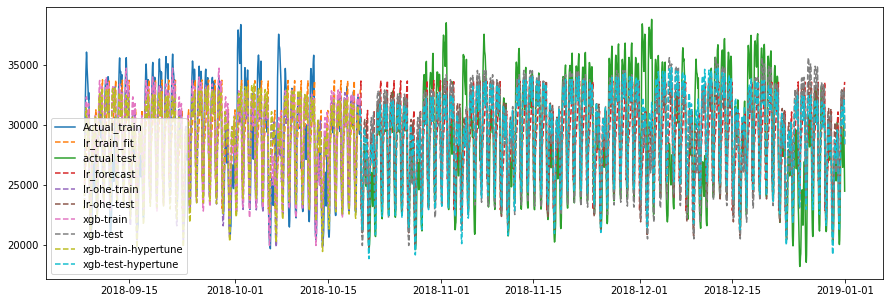

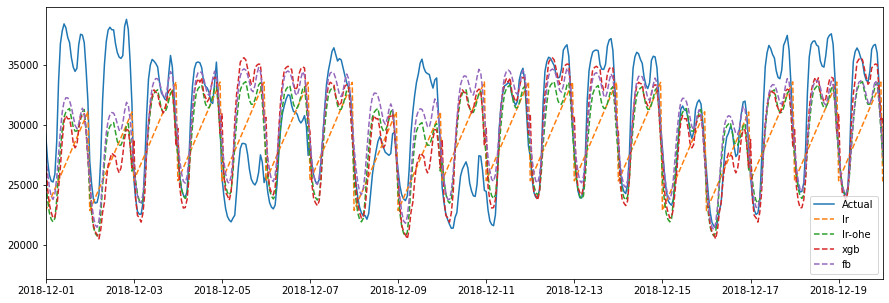

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67
0,xgb-OHE,energy,2588.74,7.0,0.68,2834.16,7.0,0.64
0,LR-OHE-exog,energy,2769.31,7.0,0.63,2724.69,7.0,0.67
0,fb,energy,2649.75,7.0,0.66,2563.49,7.0,0.7


In [92]:
plt.plot(y_train.index[-1000:], y_train[-1000:])
plt.plot(y_train.index[-1000:], train_fit_lr[-1000:], '--')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.plot(y_train.index[-1000:], train_fit_lr_2[-1000:], '--')
plt.plot(y_test.index, test_forecast_lr_2, '--')
plt.plot(y_train.index[-1000:], train_fit_xgb[-1000:], '--')
plt.plot(y_test.index, test_forecast_xgb, '--')
# plt.plot(y_train.index[-1000:], train_fit_xgb_h[-1000:], '--')
# plt.plot(y_test.index, test_forecast_xgb_h, '--')
plt.plot(train_fb.ds[-1000:], train_fit_fb.yhat[-1000:], '--')
plt.plot(test_forecast_fb.ds, test_forecast_fb.yhat, '--')
plt.legend(['Actual_train', 'lr_train_fit', 'actual test', 'lr_forecast', 'lr-ohe-train', 'lr-ohe-test', 'xgb-train', 'xgb-test', 
            'xgb-train-hypertune', 'xgb-test-hypertune', 'fb-train', 'fb-test'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

plt.plot(y_test.index, y_test)
plt.plot(y_test.index, test_forecast_lr, '--')
plt.plot(y_test.index, test_forecast_lr_2, '--')
plt.plot(y_test.index, test_forecast_xgb, '--')
# plt.plot(y_test.index, test_forecast_xgb_h, '--')
plt.plot(test_forecast_fb.ds, test_forecast_fb.yhat, '--')
plt.xlim([pd.to_datetime('2018-12-01'), pd.to_datetime('2018-12-20')])
# plt.legend(['Actual', 'lr', 'lr-ohe', 'xgb', 'xgb-h', 'fb'])
plt.legend(['Actual', 'lr', 'lr-ohe', 'xgb', 'fb'])
fig = plt.gcf()
fig.set_size_inches(15 ,5)
plt.show()

results

**Lets now see if we can improve our forecast using an exogenous variable, in this case temp_mean**

In [93]:
model = Prophet()
model.add_regressor('temp_mean')
model.fit(train_fb)

11:22:37 - cmdstanpy - INFO - Chain [1] start processing
11:22:54 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
train_fit_fb = model.predict(train_fb)
test_forecast_fb =  model.predict(test_fb)
results = update_results('fb-exog', 'energy',results, train_fb.y, train_fit_fb.yhat,test_fb.y, test_forecast_fb.yhat)
results

,model,data,train_rmse,train_mape,train_r2,test_rmse,test_mape,test_r2
0,ets,airpassenger,149.2,3.0,0.99,95.84,5.0,0.86
0,ARIMA,airpassenger,149.62,9.0,0.92,89.72,13.0,-0.5
0,SARIMA,airpassenger,151.02,4.0,0.98,99.86,3.0,0.96
0,SARIMA- PQ=1,airpassenger,150.86,4.0,0.98,96.82,3.0,0.94
0,ETS,energy,790.99,2.0,0.97,3762.39,10.0,0.36
0,LR,energy,3656.77,11.0,0.36,3711.04,11.0,0.38
0,LR-OHE,energy,2769.76,7.0,0.63,2724.7,7.0,0.67
0,xgb-OHE,energy,2588.74,7.0,0.68,2834.16,7.0,0.64
0,LR-OHE-exog,energy,2769.31,7.0,0.63,2724.69,7.0,0.67
0,fb,energy,2649.75,7.0,0.66,2563.49,7.0,0.7


**We can see that the introduction of the exogeneous variable in this case only very slightly improved the result. It is likely that the infomation assosiated with the exogenous variable correlated extremely well with the dimensions we had with time.**

If we were to continue doing this work I would look into

- Introduce lag variables into the regression 
- Introduce other exogenous variables that may not correlate so well with time. For instance precipitation level would be an interesting variable to investigate

## Conclusion
In this notebook we have looked at numerous time series techniques beyond the ETS algorithm.

- We first looked at using ARIMA/ SARIMA models to predict a time series with a single seasonality
- We then looked at how to break down a time series into its regression components to apply linear regression and XGBoost to the forecast
- We have showed how to forecast using FB Prophet 

For more detail on time series, and to really get into the technical detail of time series the following book could not be reccoended more 

https://otexts.com/fpp3/index.html